**Importar bibliotecas**

In [1]:
import os,flopy, sys, platform
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
from seaborn import load_dataset
from pandas import ExcelWriter
from pandas import ExcelFile
from openpyxl import load_workbook
from pynverse import inversefunc
from scipy.interpolate import InterpolatedUnivariateSpline

flopy is installed in C:\Users\Jerson\miniconda3\lib\site-packages\flopy


**MODELO DE FLUJO**

**Cargar Resultados del Modelo de Transporte**

In [2]:
model_ws='../4_OUT/R_SIM'
modelname='Modelo_Flujo'
exe_name= '../1_SOLVER/mf2005.exe'
mf = flopy.modflow.Modflow.load(modelname+'.nam', exe_name=exe_name, model_ws=model_ws)

**MODELO DE TRANSPORTE**

**Cargar Resultados del Modelo de Transporte**

In [3]:
namemt3d='transModel'
mt_model = flopy.mt3d.Mt3dms.load(namemt3d+'.nam',  model_ws=model_ws, version='mt3d-usgs',
                                  exe_name='../1_SOLVER/mt3d-usgs_1.1.0_64.exe', modflowmodel=mf)

In [4]:
#numero de simulaciones estocasticas
n_estocasticas=['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19',
          '20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39',
          '40','41','42','43','44','45','46','47','48','49','50','51','52','53','54','55','56','57','58','59',
          '60','61','62','63','64','65','66','67','68','69','70','71','72','73','74','75','76','77','78','79',
          '80','81','82','83','84','85','86','87','88','89','90','91','92','93','94','95','96','97','98','99'
         ]

In [5]:
t_total=[]# ingreso de masa total por cada tiempo de observacion
masa_Total=[]#masa que ha pasado por el punto de observacion a x metros
masa_Total_Ac=[]#masa acumulada que ha pasado por el punto de control ubicado a x metros
for j in n_estocasticas:
    
    #cargar resultados modelo de flujo
    headobj = bf.HeadFile(model_ws + '/'+'hds'+'/'+'Modelo_Flujo_{}.hds'.format(j))
    times = headobj.get_times()
    cbb = bf.CellBudgetFile(model_ws + '/'+'cbc'+'/'+'Modelo_Flujo_{}.cbc'.format(j))
    for iplot, time in enumerate(times):
        head = headobj.get_data(totim=time)
        #Extract flow right face and flow front face
        #frf = cbb.get_data(text='FLOW RIGHT FACE', totim=time)[0]
        #flf = cbb.get_data(text='FLOW LOWER FACE', totim=time)[0]
    
    #cargar resutlados del modelo de transporte
    fname = os.path.join(model_ws +'/'+'ucn'+'/'+'MT3D001_{}.UCN'.format(j))
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()
    fname = os.path.join(model_ws +'/'+'t_mas'+'/'+'MT3D001_{}.MAS'.format(j))
    mvt = mt_model.load_mas(fname)
    
    #suma de concentraciones en cada tiempo de observacion
    suma=[]
    for h in range(0,15):
        for k in range (0,30):
            C=(conc[h,k,0,:])
            a=[]
            for i in C:
                if i >= 0:
                    a.append(i)
            b=np.sum(a)
            suma.append(b)  
    
    t_1=np.sum(suma[0:30])
    t_2=np.sum(suma[30:60])-100*29#se resta el valor de la columna de contaminantes disponible
    t_3=np.sum(suma[60:90])-100*29#se resta el valor de la columna de contaminantes disponible
    t_4=np.sum(suma[90:120])
    t_5=np.sum(suma[120:150])
    t_6=np.sum(suma[150:180])
    t_7=np.sum(suma[180:210])
    t_8=np.sum(suma[210:240])
    t_9=np.sum(suma[240:270])
    t_10=np.sum(suma[270:300])
    t_11=np.sum(suma[300:330])
    t_12=np.sum(suma[330:360])
    t_13=np.sum(suma[360:390])
    t_14=np.sum(suma[390:420])
    t_15=np.sum(suma[420:450])
    t=[t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14,t_15]#lista de concentracion en cada tiempo de observacion
    t_total.append(t)
    
    #suma de concentraciones hacia la izquierda del punto de observacion (antes de pasar x el punto de observacion)
    suma_DIST=[]
    for z in [10,20,30,40,50,60,70,80,90]:
        for h in range(0,15):
            a_0=[]
            for k in range (0,30):
                C=(conc[h,k,0,1:z])
                a=[]
                for i in C:
                    if i > -1e+30:
                        a.append(i)
                b=np.sum(a)
                a_0.append(b)
            b_1=np.sum(a_0)
            suma_DIST.append(b_1)
    
    s_100=suma_DIST[0:15]
    s_200=suma_DIST[15:30]
    s_300=suma_DIST[30:45]
    s_400=suma_DIST[45:60]
    s_500=suma_DIST[60:75]
    s_600=suma_DIST[75:90]
    s_700=suma_DIST[90:105]
    s_800=suma_DIST[105:120]
    s_900=suma_DIST[120:135]
    
    #Calculo de masa que pasa por el punto de control ( resta de la concentracion maxima - la concentracion que aun no ha pasado)
    paso=[]
    for y in [s_100,s_200,s_300,s_400,s_500,s_600,s_700,s_800,s_900]:
        for i in y:
            a=t_4-i
            if a > 0:
                paso.append(a) 
            else:
                a=0
                paso.append(a) #valores mayores al maxima concentracion ingresada al sistema se igualan a cero
    p_100=paso[0:15]
    p_200=paso[15:30]
    p_300=paso[30:45]
    p_400=paso[45:60]
    p_500=paso[60:75]
    p_600=paso[75:90]
    p_700=paso[90:105]
    p_800=paso[105:120]
    p_900=paso[120:135]
   #reemplazar valores a 0 antes de la carga masica maxima 
    for y in [p_100,p_200,p_300,p_400,p_500,p_600,p_700,p_800,p_900]:
        for i in range (0,4):
            y[i]=0 # valores antes del tiempo t[3] se igualan a 0

    #crear lista de paso de masa por el sistema a cada distancia de observacion        
    a_0 = [p_100,p_200,p_300,p_400,p_500,p_600,p_700,p_800,p_900]
    
    masa_Total.append(a_0)
    
    #determinacion de masa acumulada
    h=[]
    for y in [p_100,p_200,p_300,p_400,p_500,p_600,p_700,p_800,p_900]:
        a=0
        for i in y:
            a = a + i
            h.append(a)
    
    amasa_ac=h[0:15]#9
    bmasa_ac=h[15:30]#19
    cmasa_ac=h[30:45]#29
    dmasa_ac=h[45:60]#39
    emasa_ac=h[60:75]#49
    fmasa_ac=h[75:90]#59
    gmasa_ac=h[90:105]#69
    hmasa_ac=h[105:120]#79
    imasa_ac=h[120:135]#89
    a_1=[amasa_ac,bmasa_ac,cmasa_ac,dmasa_ac,emasa_ac,fmasa_ac,gmasa_ac,hmasa_ac,imasa_ac]
    
    masa_Total_Ac.append(a_1)   

In [6]:
#masa_Total
#t_total

**Determinar estadisticas de las curvas de la simulacion estocastica**

In [7]:
#Calculo de curvas de referencia
p_05=[]#percentile 5
p_95=[]#percentile 95
mediana=[]
mean=[]
for j in range (0,9):
    b_1=[]
    b_2=[]
    b_m=[]
    b_mean=[]
    for k in range (0,15):
        b_3=[]
        for h in range (0,100):
            a=masa_Total[h][j][k]
            b_3.append(a)
        b_4=np.percentile(b_3,5)
        b_1.append(b_4)
        b_5=np.percentile(b_3,95)
        b_2.append(b_5)
        b_6=np.median(b_3)
        b_m.append(b_6)
        b_7=np.mean(b_3)
        b_mean.append(b_7)
    p_05.append(b_1)
    p_95.append(b_2)
    mediana.append(b_m)
    mean.append(b_mean)
#len(b)
#b

**Cargar resultados de Kriging**

In [8]:
with open('../4_OUT/R_SIM_KRIG/Curvas_Kriging.txt','r') as f:
    lineas=[linea.split() for linea in f]
#pasar a lista
k_r=[]
for j in range(0,9):
    for i in range(0,15):
        a= float(lineas[j][i])
        k_r.append(a)
k_100=k_r[0:15]
k_200=k_r[15:30]
k_300=k_r[30:45]
k_400=k_r[45:60]
k_500=k_r[60:75]
k_600=k_r[75:90]
k_700=k_r[90:105]
k_800=k_r[105:120]
k_900=k_r[120:135]
kr=[k_100,k_200,k_300,k_400,k_500,k_600,k_700,k_800,k_900]


**Transformar tiempo a años**

In [9]:
times_y=[]
for i in range(0,15):
    b = times[i]/(86400*365)
    times_y.append(b)
times_y

[3.1709791983764586e-08,
 0.00034246575342465754,
 0.027397291983764588,
 0.0547945205479452,
 0.136986301369863,
 0.2465753424657534,
 0.4931506849315068,
 1.0,
 3.002061136478945,
 5.003488077118214,
 7.004693049213597,
 30.020610857432775,
 35.03931811263318,
 50.03805175038052,
 80.05657229832572]

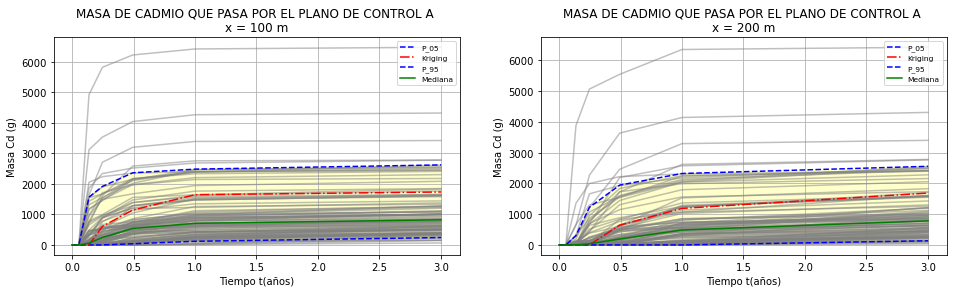

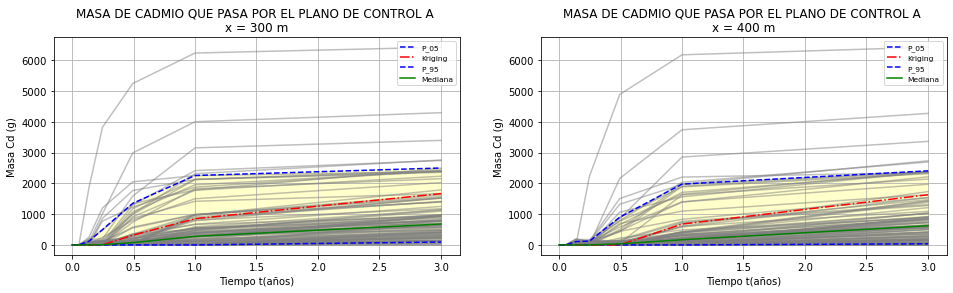

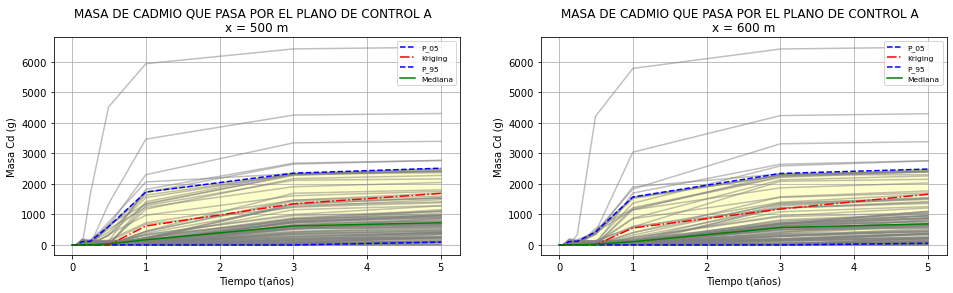

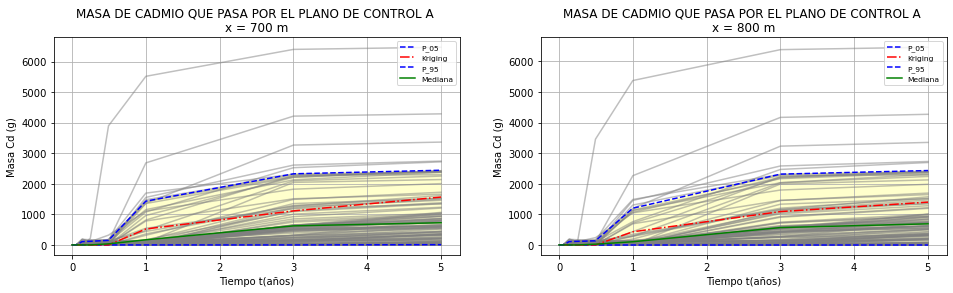

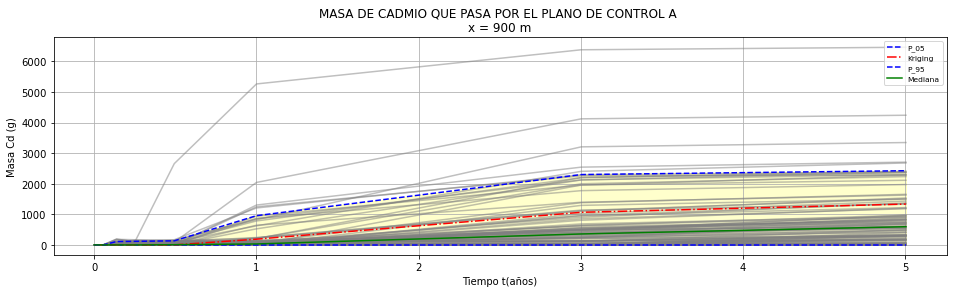

In [32]:
fig = plt.figure(figsize=(16,4))
b1=0
b2=9
for j in range (0,2):
    ax = fig.add_subplot(1, 2, j+1)
    for i in range(0,100):
        a=masa_Total[i][j]
        plt.plot(times_y[b1:b2],a[b1:b2], markersize="2", markeredgewidth="2",color="gray", alpha=0.5)

    plt.plot(times_y[b1:b2],p_05[j][b1:b2], label='P_05',linestyle='--', markersize="2", markeredgewidth="2",color="blue", alpha=1)#,  marker="o",markeredgecolor="gray")
    plt.plot(times_y[b1:b2],kr[j][b1:b2], label='Kriging',linestyle='-.',markersize="2", markeredgewidth="2",color="red", alpha=1)#,  marker="o",markeredgecolor="gray")
    plt.plot(times_y[b1:b2],p_95[j][b1:b2], label='P_95',linestyle='--', markersize="2", markeredgewidth="2",color="blue", alpha=1)#,  marker="o",markeredgecolor="gray")
    plt.plot(times_y[b1:b2],mediana[j][b1:b2], label='Mediana', markersize="2", markeredgewidth="2",color="green", alpha=1)
    #plt.plot(times_y[b1:b2],mean[j][b1:b2], label='Media', markersize="2", markeredgewidth="2",color="brown", alpha=1)
    plt.fill_between(times_y[b1:b2], p_05[j][b1:b2], p_95[j][b1:b2], color='yellow', alpha=0.2) 
    plt.title('MASA DE CADMIO QUE PASA POR EL PLANO DE CONTROL A \nx = {} m'.format((j+1)*100))
    plt.xlabel('Tiempo t(años)')
    plt.ylabel('Masa Cd (g)')
    plt.legend(loc=1, fontsize=7.5)
    plt.grid()
    #v=[times_y[b1],times_y[b2-1],a[b1],5000]
    #plt.axis(v)   
    
fig = plt.figure(figsize=(16,4))
b1=0
b2=9
for j in range (0,2):
    ax = fig.add_subplot(1, 2, j+1)
    for i in range(0,100):
        a=masa_Total[i][j+2]
        plt.plot(times_y[b1:b2],a[b1:b2], markersize="2", markeredgewidth="2",color="gray", alpha=0.5)
    #Graficar lineas de referencia
    n=2
    plt.plot(times_y[b1:b2],p_05[j+n][b1:b2], label='P_05',linestyle='--', markersize="2", markeredgewidth="2",color="blue", alpha=1)#,  marker="o",markeredgecolor="gray")
    plt.plot(times_y[b1:b2],kr[j+n][b1:b2], label='Kriging',linestyle='-.',markersize="2", markeredgewidth="2",color="red", alpha=1)#,  marker="o",markeredgecolor="gray")
    plt.plot(times_y[b1:b2],p_95[j+n][b1:b2], label='P_95',linestyle='--', markersize="2", markeredgewidth="2",color="blue", alpha=1)#,  marker="o",markeredgecolor="gray")
    plt.plot(times_y[b1:b2],mediana[j+n][b1:b2], label='Mediana', markersize="2", markeredgewidth="2",color="green", alpha=1)
    #plt.plot(times_y[b1:b2],mean[j+n][b1:b2], label='Media', markersize="2", markeredgewidth="2",color="brown", alpha=1)
    #dibujar relleno tenue de color rojo
    plt.fill_between(times_y[b1:b2], p_05[j+n][b1:b2], p_95[j+n][b1:b2], color='yellow', alpha=0.2) 
    plt.title('MASA DE CADMIO QUE PASA POR EL PLANO DE CONTROL A \nx = {} m'.format((j+3)*100))
    plt.xlabel('Tiempo t(años)')
    plt.ylabel('Masa Cd (g)')
    plt.legend(loc=1, fontsize=7.5)    
    plt.grid()
   
    
fig = plt.figure(figsize=(16,4))
b1=0
b2=10
for j in range (0,2):
    ax = fig.add_subplot(1, 2, j+1)
    for i in range(0,100):
        a=masa_Total[i][j+4]
        plt.plot(times_y[b1:b2],a[b1:b2], markersize="2", markeredgewidth="2",color="gray", alpha=0.5)

    m=4
    plt.plot(times_y[b1:b2],p_05[j+m][b1:b2], label='P_05',linestyle='--', markersize="2", markeredgewidth="2",color="blue", alpha=1)#,  marker="o",markeredgecolor="gray")
    plt.plot(times_y[b1:b2],kr[j+m][b1:b2], label='Kriging',linestyle='-.',markersize="2", markeredgewidth="2",color="red", alpha=1)#,  marker="o",markeredgecolor="gray")
    plt.plot(times_y[b1:b2],p_95[j+m][b1:b2], label='P_95',linestyle='--', markersize="2", markeredgewidth="2",color="blue", alpha=1)#,  marker="o",markeredgecolor="gray")
    plt.plot(times_y[b1:b2],mediana[j+3][b1:b2], label='Mediana', markersize="2", markeredgewidth="2",color="green", alpha=1)
    #plt.plot(times_y[b1:b2],mean[j+m][b1:b2], label='Media', markersize="2", markeredgewidth="2",color="brown", alpha=1)
    plt.fill_between(times_y[b1:b2], p_05[j+m][b1:b2], p_95[j+m][b1:b2], color='yellow', alpha=0.2) 
    plt.title('MASA DE CADMIO QUE PASA POR EL PLANO DE CONTROL A  \nx = {} m'.format((j+5)*100))
    plt.xlabel('Tiempo t(años)')
    plt.ylabel('Masa Cd (g)')
    plt.legend(loc=1, fontsize=7.5)
    plt.grid()
   
fig = plt.figure(figsize=(16,4))
b1=0
b2=10
for j in range (0,2):
    ax = fig.add_subplot(1, 2, j+1)
    for i in range(0,100):
        a=masa_Total[i][j+6]
        plt.plot(times_y[b1:b2],a[b1:b2], markersize="2", markeredgewidth="2",color="gray", alpha=0.5)

    m=6
    plt.plot(times_y[b1:b2],p_05[j+m][b1:b2], label='P_05',linestyle='--', markersize="2", markeredgewidth="2",color="blue", alpha=1)#,  marker="o",markeredgecolor="gray")
    plt.plot(times_y[b1:b2],kr[j+m][b1:b2], label='Kriging',linestyle='-.',markersize="2", markeredgewidth="2",color="red", alpha=1)#,  marker="o",markeredgecolor="gray")
    plt.plot(times_y[b1:b2],p_95[j+m][b1:b2], label='P_95',linestyle='--', markersize="2", markeredgewidth="2",color="blue", alpha=1)#,  marker="o",markeredgecolor="gray")
    plt.plot(times_y[b1:b2],mediana[j+3][b1:b2], label='Mediana', markersize="2", markeredgewidth="2",color="green", alpha=1)
    #plt.plot(times_y[b1:b2],mean[j+m][b1:b2], label='Media', markersize="2", markeredgewidth="2",color="brown", alpha=1)
    plt.fill_between(times_y[b1:b2], p_05[j+m][b1:b2], p_95[j+m][b1:b2], color='yellow', alpha=0.2) 
    plt.title('MASA DE CADMIO QUE PASA POR EL PLANO DE CONTROL A \nx = {} m'.format((j+7)*100))
    plt.xlabel('Tiempo t(años)')
    plt.ylabel('Masa Cd (g)')
    plt.legend(loc=1, fontsize=7.5)
    plt.grid()
   
    
fig = plt.figure(figsize=(16,4))
b1=0
b2=10
for j in range (0,1):
    ax = fig.add_subplot(1, 1, j+1)
    for i in range(0,100):
        a=masa_Total[i][j+8]
        plt.plot(times_y[b1:b2],a[b1:b2], markersize="2", markeredgewidth="2",color="gray", alpha=0.5)

    l=8
    plt.plot(times_y[b1:b2],p_05[j+l][b1:b2], label='P_05',linestyle='--', markersize="2", markeredgewidth="2",color="blue", alpha=1)#,  marker="o",markeredgecolor="gray")
    plt.plot(times_y[b1:b2],kr[j+l][b1:b2], label='Kriging',linestyle='-.',markersize="2", markeredgewidth="2",color="red", alpha=1)#,  marker="o",markeredgecolor="gray")
    plt.plot(times_y[b1:b2],p_95[j+l][b1:b2], label='P_95',linestyle='--', markersize="2", markeredgewidth="2",color="blue", alpha=1)#,  marker="o",markeredgecolor="gray")
    plt.plot(times_y[b1:b2],mediana[j+l][b1:b2], label='Mediana', markersize="2", markeredgewidth="2",color="green", alpha=1)
    #plt.plot(times_y[b1:b2],mean[j+l][b1:b2], label='Media', markersize="2", markeredgewidth="2",color="brown", alpha=1)
    
    plt.fill_between(times_y[b1:b2], p_05[j+l][b1:b2], p_95[j+l][b1:b2], color='yellow', alpha=0.2) 
    
    plt.title('MASA DE CADMIO QUE PASA POR EL PLANO DE CONTROL A \nx = {} m'.format((j+9)*100))
    plt.xlabel('Tiempo t(años)')
    plt.ylabel('Masa Cd (g)')
    plt.legend(loc=1, fontsize=7.5)
    plt.grid()

plt.show()

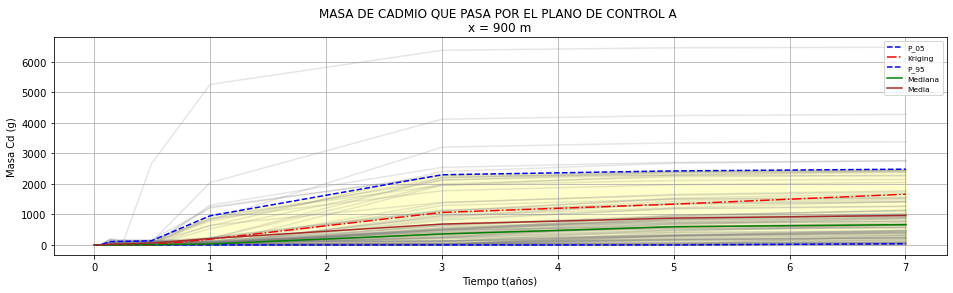

In [11]:
fig = plt.figure(figsize=(16,4))
b1=0
b2=11
for j in range (0,1):
    ax = fig.add_subplot(1, 1, j+1)
    for i in range(0,100):
        a=masa_Total[i][j+8]
        plt.plot(times_y[b1:b2],a[b1:b2], markersize="2", markeredgewidth="2",color="gray", alpha=0.2)

    l=8
    plt.plot(times_y[b1:b2],p_05[j+l][b1:b2], label='P_05',linestyle='--', markersize="2", markeredgewidth="2",color="blue", alpha=1)#,  marker="o",markeredgecolor="gray")
    plt.plot(times_y[b1:b2],kr[j+l][b1:b2], label='Kriging',linestyle='-.',markersize="2", markeredgewidth="2",color="red", alpha=1)#,  marker="o",markeredgecolor="gray")
    plt.plot(times_y[b1:b2],p_95[j+l][b1:b2], label='P_95',linestyle='--', markersize="2", markeredgewidth="2",color="blue", alpha=1)#,  marker="o",markeredgecolor="gray")
    plt.plot(times_y[b1:b2],mediana[j+l][b1:b2], label='Mediana', markersize="2", markeredgewidth="2",color="green", alpha=1)
    plt.plot(times_y[b1:b2],mean[j+l][b1:b2], label='Media', markersize="2", markeredgewidth="2",color="brown", alpha=1)

    plt.fill_between(times_y[b1:b2], p_05[j+l][b1:b2], p_95[j+l][b1:b2], color='yellow', alpha=0.2) 
    
    plt.title('MASA DE CADMIO QUE PASA POR EL PLANO DE CONTROL A \nx = {} m'.format((j+9)*100))
    plt.xlabel('Tiempo t(años)')
    plt.ylabel('Masa Cd (g)')
    plt.legend(loc=1, fontsize=7.5)
    plt.grid()

plt.show()

In [12]:
Suma_Total=[]
S_90=[]#paso del 90% del contaminate
S_75=[]#paso del 75% del contaminate
S_50=[]#paso del 50% del contaminate
S_25=[]#paso del 25% del contaminate
for j in n_estocasticas:

    headobj = bf.HeadFile(model_ws + '/'+'hds'+'/'+'Modelo_Flujo_{}.hds'.format(j))
    times = headobj.get_times()
    cbb = bf.CellBudgetFile(model_ws + '/'+'cbc'+'/'+'Modelo_Flujo_{}.cbc'.format(j))
    for iplot, time in enumerate(times):
        head = headobj.get_data(totim=time)
        #Extract flow right face and flow front face
        #frf = cbb.get_data(text='FLOW RIGHT FACE', totim=time)[0]
        #flf = cbb.get_data(text='FLOW LOWER FACE', totim=time)[0]
    
    fname = os.path.join(model_ws +'/'+'ucn'+'/'+'MT3D001_{}.UCN'.format(j))
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()
    fname = os.path.join(model_ws +'/'+'t_mas'+'/'+'MT3D001_{}.MAS'.format(j))
    mvt = mt_model.load_mas(fname)
    #calculo de masa total que ingresa al sistema en cada simulacion 
    suma=[]
    for h in range(0,15):
        for k in range (0,30):
            C=(conc[h,k,0,:])
            a=[]
            for i in C:
                if i >= 0:
                    a.append(i)
            b=np.sum(a)
            suma.append(b)  

    t_1=np.sum(suma[0:30])
    t_2=np.sum(suma[30:60])-100*29
    t_3=np.sum(suma[60:90])-100*29
    t_4=np.sum(suma[90:120])
    t_5=np.sum(suma[120:150])
    t_6=np.sum(suma[150:180])
    t_7=np.sum(suma[180:210])
    t_8=np.sum(suma[210:240])
    t_9=np.sum(suma[240:270])
    t_10=np.sum(suma[270:300])
    t_11=np.sum(suma[300:330])
    t_12=np.sum(suma[330:360])
    t_13=np.sum(suma[360:390])
    t_14=np.sum(suma[390:420])
    t_15=np.sum(suma[420:450])
    t=[t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14,t_15]
    Suma_Total.append(t)
    #interpolacion de puntos de tiempo de observacion en cada modelo 
    f_interp90=InterpolatedUnivariateSpline(times,t,k=1,ext=0)
    f_interp75=InterpolatedUnivariateSpline(times,t,k=1,ext=0)
    f_interp50=InterpolatedUnivariateSpline(times,t,k=1,ext=0)
    f_interp25=InterpolatedUnivariateSpline(times,t,k=1,ext=0)
    #calculo de puntos de interseccion de valores de concentraciones presentes en el sistema
    inverse_90 = inversefunc(f_interp90, y_values=(t[3]*.10), domain=(times[4],times[14]),open_domain=False, image=(times[0],times[14]))
    inverse_75 = inversefunc(f_interp75, y_values=(t[3]*.25), domain=(times[4],times[14]),open_domain=False, image=(times[0],times[14]))
    inverse_50 = inversefunc(f_interp50, y_values=(t[3]*.50), domain=(times[4],times[14]),open_domain=False, image=(times[0],times[14]))
    inverse_25 = inversefunc(f_interp25, y_values=(t[3]*.75), domain=(times[4],times[14]),open_domain=False, image=(times[0],times[14]))
    
    S_90.append(inverse_90)
    S_75.append(inverse_75)
    S_50.append(inverse_50)
    S_25.append(inverse_25)
    

In [13]:
#Calculo de cponcentracion maxima ingresada al sistema (tiempo t[3], luego eliminar fuente de cadmio)
Total_ingreso=[]
for i in range (0,100):
    a=Suma_Total[i][3]
    Total_ingreso.append(a)
Total_ingreso[89]

6481.6159211095655

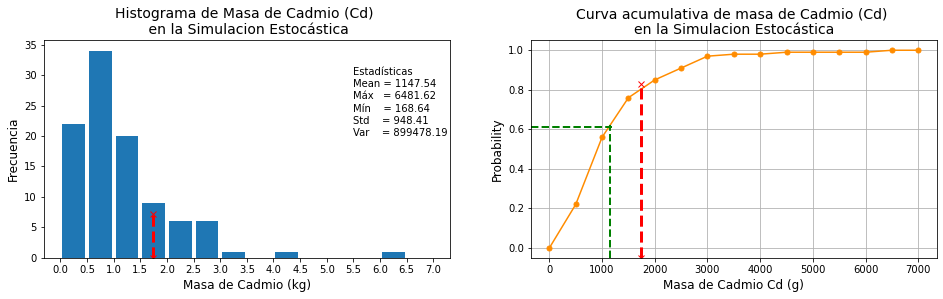

In [14]:
#Estadisticas
m=np.mean(Total_ingreso)
ma=np.max(Total_ingreso)
mi=np.min(Total_ingreso)
de=np.std(Total_ingreso)
va=np.var(Total_ingreso)

#Titulo de estadisticas
w_1 = "Mean = {:.2f}".format(m)
w_2 = "Máx   = {:.2f}".format(ma)
w_3 = "Mín    = {:.2f}".format(mi)
w_4 = "Std    = {:.2f}".format(de)
w_5 = "Var    = {:.2f}".format(va)
v=[w_1,w_2,w_3,w_4,w_5]
#v
krig=1734
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1, 2, 1)
intervalos = np.arange(0,7500,500) 
#indicamos los extremos de los intervalos
values, base, _ = plt.hist(x=Total_ingreso, bins=intervalos, rwidth=0.85)
plt.title('Histograma de Masa de Cadmio (Cd) \n en la Simulacion Estocástica',fontsize=14)
plt.xlabel('Masa de Cadmio (kg)',fontsize=12)
plt.ylabel('Frecuencia',fontsize=12)
plt.xticks(intervalos,np.arange(0,7.5,.5))
plt.axvline(x=krig, ymin=0, ymax=.2,color='r', linestyle='dashed',  marker='x',linewidth=3)

#plt.axvspan(1000,1500,color='g',alpha=0.2) 
a1=5500
b1=30
b2=2
plt.text(a1, b1,"Estadísticas",)
plt.text(a1, b1-b2, v[0])
plt.text(a1, b1-2*b2, v[1])
plt.text(a1, b1-3*b2, v[2])
plt.text(a1, b1-4*b2, v[3])
plt.text(a1, b1-5*b2, v[4])
#plt.grid()


ax = fig.add_subplot(1, 2, 2)
values = np.insert(values,0,0)
ax.plot(base, np.cumsum(values)/ np.cumsum(values)[-1], color='darkorange', 
            marker='o', linestyle='-', markersize = 5, label = "Cumulative Histogram" )
plt.axvline(m, color='g',ymax=.61, linestyle='dashed', linewidth=2)
plt.axhline(y=.61, color='g',xmin=0, xmax=0.2, linestyle='dashed', linewidth=2)
plt.axvline(krig, color='r',ymax=.8, linestyle='dashed',  marker='x',linewidth=3)
plt.title('Curva acumulativa de masa de Cadmio (Cd) \nen la Simulacion Estocástica',fontsize=14)
plt.xlabel('Masa de Cadmio Cd (g)',fontsize=12)
plt.ylabel("Probability",fontsize=12)
plt.grid()
plt.show() #dibujamos el histograma
#axhspan(0, 2, alpha=0.3, color='b') #resaltar por banda

In [15]:
len(np.arange(0,7500,250)) 
np.cumsum(values)
values= np.insert(values,0,0)
values

array([ 0.,  0., 22., 34., 20.,  9.,  6.,  6.,  1.,  0.,  1.,  0.,  0.,
        0.,  1.,  0.])

In [16]:
a90=np.array(S_90).tolist()
year_ar90=[]
for i in range(0,100):
    b90 = a90[i]/(86400*365)
    year_ar90.append(b90)

a75=np.array(S_75).tolist()
year_ar75=[]
for i in range(0,100):
    b75 = a75[i] /(86400*365)
    year_ar75.append(b75)

a50=np.array(S_50).tolist()
year_ar50=[]
for i in range(0,100):
    b50 = a50[i] / (86400*365)
    year_ar50.append(b50)

a25=np.array(S_25).tolist()
year_ar25=[]
for i in range(0,100):
    b25 = a25[i] / (86400*365)
    year_ar25.append(b25)
    

In [17]:
year_ar90[37]

2.8432717953432354

In [18]:
print(np.min(Total_ingreso))
print(np.max(Total_ingreso))
print(Total_ingreso[94])
print(Total_ingreso[89])
#Total_ingreso

168.6421890258789
6481.6159211095655
168.6421890258789
6481.6159211095655


In [19]:
tkrig=[6.455589983685429,4.668145174003786,2.467664864331283]
#year_ar90

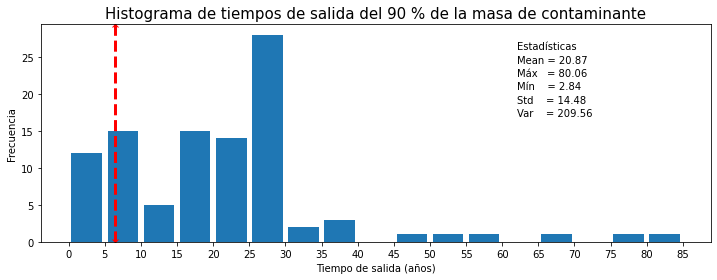

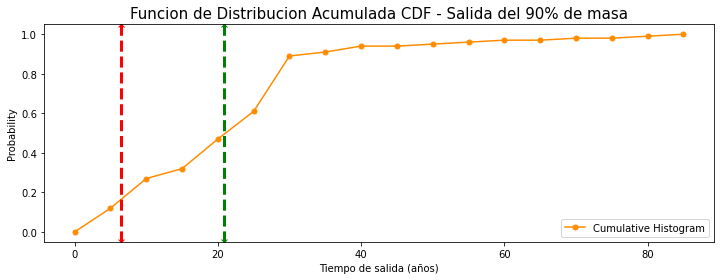

In [20]:
lista=year_ar90
#Estadisticas
m=np.mean(lista)
ma=np.max(lista)
mi=np.min(lista)
de=np.std(lista)
va=np.var(lista)

#Titulo de estadisticas
w_1 = "Mean = {:.2f}".format(m)
w_2 = "Máx   = {:.2f}".format(ma)
w_3 = "Mín    = {:.2f}".format(mi)
w_4 = "Std    = {:.2f}".format(de)
w_5 = "Var    = {:.2f}".format(va)
v=[w_1,w_2,w_3,w_4,w_5]
#v

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 1, 1)
intervalos = np.arange(0,86,5) 
#indicamos los extremos de los intervalos
plt.axvline(tkrig[0], color='r', linestyle='dashed',  marker='x',linewidth=3)
values, base, _ =plt.hist(x=year_ar90, bins=intervalos, rwidth=0.85)#, #color='b')
plt.title('Histograma de tiempos de salida del 90 % de la masa de contaminante',fontsize=15)
plt.xlabel('Tiempo de salida (años)')
plt.ylabel('Frecuencia')
plt.xticks(intervalos)
b1=26
b2=1.8
plt.text(62, b1,"Estadísticas",)
plt.text(62, b1-b2, v[0])
plt.text(62, b1-2*b2, v[1])
plt.text(62, b1-3*b2, v[2])
plt.text(62, b1-4*b2, v[3])
plt.text(62, b1-5*b2, v[4])
#plt.grid()

#calculo de CDF

fig = plt.figure(figsize=(12,4))
ax = plt.axes()
values = np.insert(values,0,0)
ax.plot( base, np.cumsum(values)/ np.cumsum(values)[-1], color='darkorange', 
            marker='o', linestyle='-', markersize = 5, label = "Cumulative Histogram" )
#plt.axhline(0.66, color='r', linestyle='dashed',  marker='<',linewidth=3)
plt.axvline(tkrig[0], color='r', linestyle='dashed',  marker='x',linewidth=3)
plt.axvline(m, color='g', linestyle='dashed',  marker='x',linewidth=3)
plt.xlabel('Tiempo de salida (años)')
plt.ylabel("Probability")
plt.title('Funcion de Distribucion Acumulada CDF - Salida del 90% de masa',fontsize=15)

ax.legend()

plt.show() #dibujamos el histograma


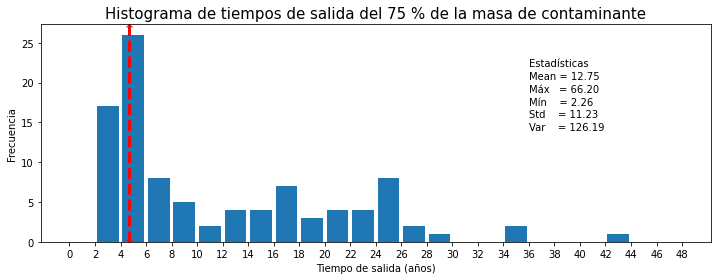

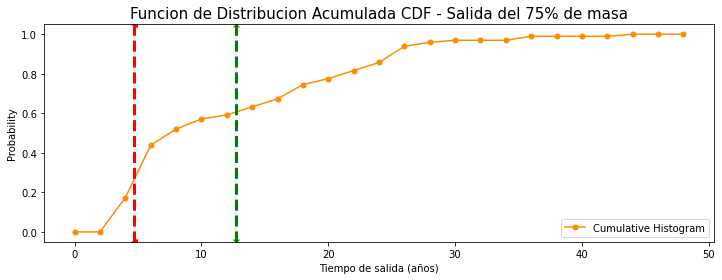

In [21]:
lista=year_ar75
#Estadisticas
m=np.mean(lista)
ma=np.max(lista)
mi=np.min(lista)
de=np.std(lista)
va=np.var(lista)

#Titulo de estadisticas
w_1 = "Mean = {:.2f}".format(m)
w_2 = "Máx   = {:.2f}".format(ma)
w_3 = "Mín    = {:.2f}".format(mi)
w_4 = "Std    = {:.2f}".format(de)
w_5 = "Var    = {:.2f}".format(va)
v=[w_1,w_2,w_3,w_4,w_5]
#v

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 1, 1)
intervalos = np.arange(0,50,2) 
#indicamos los extremos de los intervalos
values, base, _ = plt.hist(x=year_ar75, bins=intervalos, rwidth=0.85) #color='b')
plt.title('Histograma de tiempos de salida del 75 % de la masa de contaminante',fontsize=15)
plt.xlabel('Tiempo de salida (años)')
plt.ylabel('Frecuencia')
plt.xticks(intervalos)
l=36
b1=22
b2=1.6
plt.text(l, b1,"Estadísticas",)
plt.text(l, b1-b2, v[0])
plt.text(l, b1-2*b2, v[1])
plt.text(l, b1-3*b2, v[2])
plt.text(l, b1-4*b2, v[3])
plt.text(l, b1-5*b2, v[4])
plt.axvline(tkrig[1], color='r', linestyle='dashed',  marker='x',linewidth=3)
#plt.grid()

#calculo de CDF

fig = plt.figure(figsize=(12,4))
ax = plt.axes()
values = np.insert(values,0,0)
ax.plot( base, np.cumsum(values)/ np.cumsum(values)[-1], color='darkorange', 
            marker='o', linestyle='-', markersize = 5, label = "Cumulative Histogram" )
plt.axvline(tkrig[1], color='r', linestyle='dashed',  marker='<',linewidth=3)
plt.axvline(m, color='g', linestyle='dashed',  marker='x',linewidth=3)
plt.xlabel('Tiempo de salida (años)')
plt.ylabel("Probability")
plt.title('Funcion de Distribucion Acumulada CDF - Salida del 75% de masa',fontsize=15)

ax.legend()

plt.show() #dibujamos el histograma

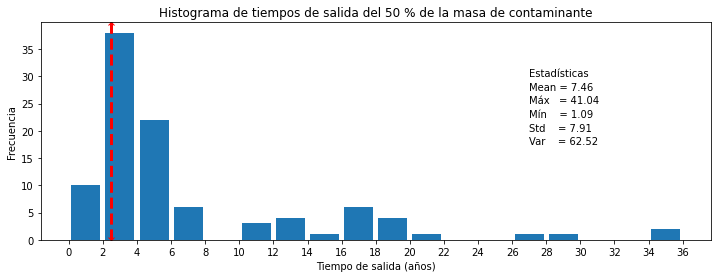

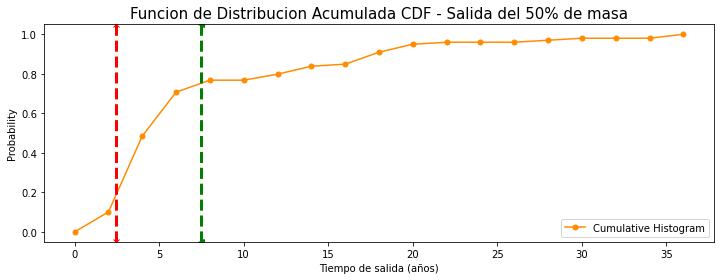

In [22]:
lista=year_ar50
#Estadisticas
m=np.mean(lista)
ma=np.max(lista)
mi=np.min(lista)
de=np.std(lista)
va=np.var(lista)

#Titulo de estadisticas
w_1 = "Mean = {:.2f}".format(m)
w_2 = "Máx   = {:.2f}".format(ma)
w_3 = "Mín    = {:.2f}".format(mi)
w_4 = "Std    = {:.2f}".format(de)
w_5 = "Var    = {:.2f}".format(va)
v=[w_1,w_2,w_3,w_4,w_5]
#v

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 1, 1)
intervalos = np.arange(0,37,2) 
#indicamos los extremos de los intervalos
values, base, _ =plt.hist(x=year_ar50, bins=intervalos, rwidth=0.85) #color='b')
plt.title('Histograma de tiempos de salida del 50 % de la masa de contaminante')
plt.xlabel('Tiempo de salida (años)')
plt.ylabel('Frecuencia')
plt.xticks(intervalos)
l=27
b1=30
b2=2.5
plt.text(l, b1,"Estadísticas",)
plt.text(l, b1-b2, v[0])
plt.text(l, b1-2*b2, v[1])
plt.text(l, b1-3*b2, v[2])
plt.text(l, b1-4*b2, v[3])
plt.text(l, b1-5*b2, v[4])
plt.axvline(tkrig[2], color='r', linestyle='dashed',  marker='x',linewidth=3)
#plt.grid()

#calculo de CDF

fig = plt.figure(figsize=(12,4))
ax = plt.axes()
values = np.insert(values,0,0)
ax.plot( base, np.cumsum(values)/ np.cumsum(values)[-1], color='darkorange', 
            marker='o', linestyle='-', markersize = 5, label = "Cumulative Histogram" )
plt.axvline(m, color='g', linestyle='dashed',  marker='<',linewidth=3)
plt.axvline(tkrig[2], color='r', linestyle='dashed',  marker='x',linewidth=3)
plt.xlabel('Tiempo de salida (años)')
plt.ylabel("Probability")
plt.title('Funcion de Distribucion Acumulada CDF - Salida del 50% de masa',fontsize=15)

ax.legend()

plt.show() #dibujamos el histograma

lista=year_ar25
#Estadisticas
m=np.mean(lista)
#ma=np.max(lista)
mi=np.min(lista)
de=np.std(lista)
va=np.var(lista)

#Titulo de estadisticas
w_1 = "Mean = {:.2f}".format(m)
w_2 = "Máx   = {:.2f}".format(ma)
w_3 = "Mín    = {:.2f}".format(mi)
w_4 = "Std    = {:.2f}".format(de)
w_5 = "Var    = {:.2f}".format(va)
v=[w_1,w_2,w_3,w_4,w_5]
#v

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1, 1, 1)
intervalos = np.arange(0,38,2) 
#indicamos los extremos de los intervalos
plt.hist(x=year_ar25, bins=intervalos, rwidth=0.85), #color='b')
plt.title('Tiempos de salida del 25 % de la masa de contaminante')
plt.xlabel('Tiempo de llegada (años)')
plt.ylabel('Frecuencia')
plt.xticks(intervalos)
b1=37
b2=2
plt.text(32, b1,"Estadísticas",)
plt.text(32, b1-b2, v[0])
plt.text(32, b1-2*b2, v[1])
plt.text(32, b1-3*b2, v[2])
plt.text(32, b1-4*b2, v[3])
plt.text(32, b1-5*b2, v[4])
#plt.grid()
plt.show() #dibujamos el histograma

# incetidumbre evaluada a cada distancia
masa_Total[99][0]
#t_total[1]
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1, 1, 1)
t_90=[]
b_1=0
b_2=11
for z in range (0,100):
    plt.plot(times_y[b_1:b_2],masa_Total[z][0][b_1:b_2], label='Masa de Cd', marker="D", markersize="2", markeredgewidth="2",
         markerfacecolor="b", markeredgecolor="b")
    f_interp=InterpolatedUnivariateSpline(times_y,masa_Total[z][0],k=1)
    times1=np.linspace(times_y[b_1:b_2],times_y[b_1:b_2],300)
    t1=f_interp(times1)
    plt.plot(times1,t1)
    #plt.fill_between(times1,t1,color='red', alpha=0.2)
    #plt.axhline(t_total[z][3]*.9, color='r', linestyle='dashed', linewidth=1)


    inverse_90= inversefunc(f_interp, y_values=(t_total[z][3]*.9), domain=(times[0],times[13]), image=(times[0],times[13]))
    t_90.append(inverse_90)

#plt.axvline(inverse_90, color='r', linestyle='dashed', linewidth=1)

In [23]:
# incetidumbre evaluada a cada distancia

t_90=[]
b_1=0
b_2=15
for j in range (0,9):
    for z in range (0,100):
        f_interp=InterpolatedUnivariateSpline(times_y,masa_Total[z][j],k=1)
        inverse_90= inversefunc(f_interp, y_values=(t_total[z][3]*.9), domain=(times[0],times[13]), image=(times[0],times[13]))
        t_90.append(inverse_90)

t_90
tiempo_90=np.array(t_90).tolist()
len(tiempo_90)

900

In [24]:
#separar paso del porcentaje de masa por los puntos de control
ts_100=tiempo_90[0:100]
ts_200=tiempo_90[100:200]
ts_300=tiempo_90[200:300]
ts_400=tiempo_90[300:400]
ts_500=tiempo_90[400:500]
ts_600=tiempo_90[500:600]
ts_700=tiempo_90[600:700]
ts_800=tiempo_90[700:800]
ts_900=tiempo_90[800:900]
#ts_100

In [25]:
t_100ok=ts_100
t_100ok[12]=0.46
t_100ok[33]=0.82
t_100ok[54]=2.25
t_100ok[63]=0.53
t_100ok[66]=2.73
t_100ok[70]=0.89
t_100ok[89]=0.32
t_200ok=ts_200
t_200ok[12]=0.88
t_300ok=ts_300
t_300ok[94]=35
t_400ok=ts_400
t_400ok[23]=2.35
t_500ok=ts_500
t_500ok[12]=2.62
t_500ok[23]=2.69
t_600ok=ts_600
t_600ok[23]=2.83
t_600ok[89]=1.37
t_700ok=ts_700
t_700ok[23]=2.89
t_800ok=ts_800
t_800ok[12]=2.9
t_800ok[23]=2.93
t_900ok=ts_900
t_900ok[9]=3.96
t_900ok[23]=2.96
#t_500ok

In [26]:
#tiempos para que salga el 90% a distitnas distancias
Kriging=[0.91,2.56,2.76,2.84,4.32,4.66,5.12,6.33,6.5]
print(t_100ok[86],t_200ok[86],t_300ok[86],t_400ok[86],t_500ok[86],t_600ok[86],t_700ok[86],t_800ok[86],t_900ok[86])
print(t_100ok[94],t_200ok[94],t_300ok[94],t_400ok[94],t_500ok[86],t_600ok[86],t_700ok[86],t_800ok[86],t_900ok[86])
print(t_200ok[89],t_300ok[12],t_400ok[59],t_500ok[86],t_600ok[86],t_700ok[86],t_800ok[86],t_900ok[86])
#t_100ok

8.081937022857314 21.80154301568844 25.533792173856337 28.37376098680444 2.215411329620329 49.34433540696945 60.511062612312166 67.3275405354162 73.75471660628587
26.122794292000634 32.55835993317786 35 40.94587709485221 2.215411329620329 49.34433540696945 60.511062612312166 67.3275405354162 73.75471660628587
1.0000000172268673 35.039318383159326 27.53337925389108 2.215411329620329 49.34433540696945 60.511062612312166 67.3275405354162 73.75471660628587


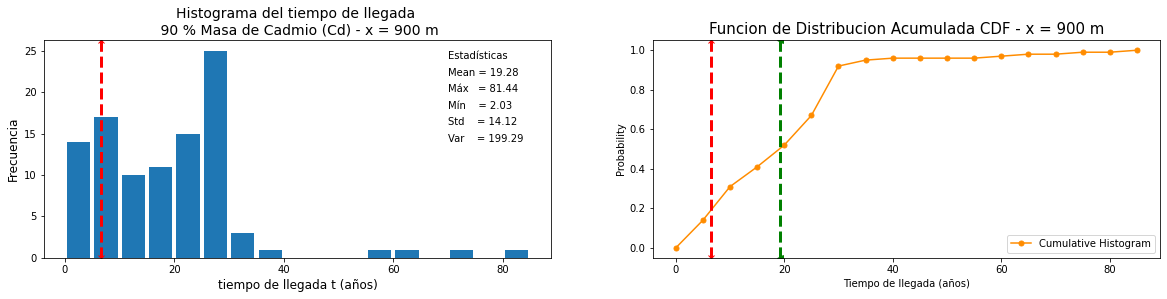

In [27]:
#grafica a 900 metros
K=t_900ok
n=8
m=np.mean(K)
ma=np.max(K)
mi=np.min(K)
de=np.std(K)
va=np.var(K)

#Titulo de estadisticas
w_1 = "Mean = {:.2f}".format(m)
w_2 = "Máx   = {:.2f}".format(ma)
w_3 = "Mín    = {:.2f}".format(mi)
w_4 = "Std    = {:.2f}".format(de)
w_5 = "Var    = {:.2f}".format(va)
v=[w_1,w_2,w_3,w_4,w_5]

fig = plt.figure(figsize=(20,4))

ax = fig.add_subplot(1, 2, 1)
intervalos = np.arange(0,86,5) 
#indicamos los extremos de los intervalos
values, base, _ = plt.hist(x=K,bins=intervalos, rwidth=0.85)
plt.title('Histograma del tiempo de llegada \n 90 % Masa de Cadmio (Cd) - x = 900 m',fontsize=14)
plt.xlabel('tiempo de llegada t (años)',fontsize=12)
plt.ylabel('Frecuencia',fontsize=12)
plt.axvline(Kriging[n], color='r', linestyle='dashed',  marker='x',linewidth=3)

b1=24
b2=2
c=70
plt.text(c, b1,"Estadísticas",)
plt.text(c, b1-b2, v[0])
plt.text(c, b1-2*b2, v[1])
plt.text(c, b1-3*b2, v[2])
plt.text(c, b1-4*b2, v[3])
plt.text(c, b1-5*b2, v[4])
#calculo de CDF

ax = fig.add_subplot(1, 2, 2)

values = np.insert(values,0,0)
ax.plot(base, np.cumsum(values)/ np.cumsum(values)[-1], color='darkorange', 
            marker='o', linestyle='-', markersize = 5, label = "Cumulative Histogram" )
#plt.axhline(0.95, color='r', linestyle='dashed',  marker='<',linewidth=3)
plt.xlabel('Tiempo de llegada (años)')
plt.ylabel("Probability")
plt.title('Funcion de Distribucion Acumulada CDF - x = 900 m',fontsize=15)
plt.axvline(Kriging[n], color='r', linestyle='dashed',  marker='x',linewidth=3)
plt.axvline(m, color='g', linestyle='dashed',  marker='<',linewidth=3)
ax.legend()

plt.show() #dibujamos el histograma

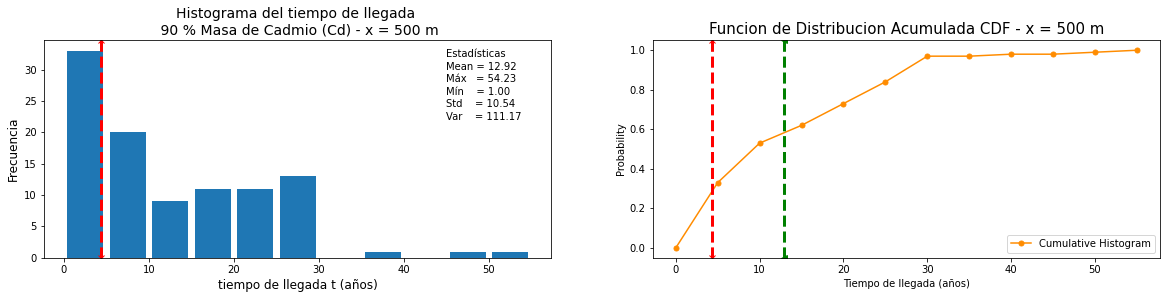

In [28]:
#grafica a 900 metros
K=t_500ok
n=4
m=np.mean(K)
ma=np.max(K)
mi=np.min(K)
de=np.std(K)
va=np.var(K)

#Titulo de estadisticas
w_1 = "Mean = {:.2f}".format(m)
w_2 = "Máx   = {:.2f}".format(ma)
w_3 = "Mín    = {:.2f}".format(mi)
w_4 = "Std    = {:.2f}".format(de)
w_5 = "Var    = {:.2f}".format(va)
v=[w_1,w_2,w_3,w_4,w_5]

fig = plt.figure(figsize=(20,4))

ax = fig.add_subplot(1, 2, 1)
intervalos = np.arange(0,60,5) 
#indicamos los extremos de los intervalos
values, base, _ = plt.hist(x=K,bins=intervalos, rwidth=0.85)
plt.title('Histograma del tiempo de llegada \n 90 % Masa de Cadmio (Cd) - x = 500 m',fontsize=14)
plt.xlabel('tiempo de llegada t (años)',fontsize=12)
plt.ylabel('Frecuencia',fontsize=12)
plt.axvline(Kriging[n], color='r', linestyle='dashed',  marker='x',linewidth=3)

b1=32
b2=2
c=45
plt.text(c, b1,"Estadísticas",)
plt.text(c, b1-b2, v[0])
plt.text(c, b1-2*b2, v[1])
plt.text(c, b1-3*b2, v[2])
plt.text(c, b1-4*b2, v[3])
plt.text(c, b1-5*b2, v[4])
#calculo de CDF

ax = fig.add_subplot(1, 2, 2)

values = np.insert(values,0,0)
ax.plot(base, np.cumsum(values)/ np.cumsum(values)[-1], color='darkorange', 
            marker='o', linestyle='-', markersize = 5, label = "Cumulative Histogram" )
#plt.axhline(0.95, color='r', linestyle='dashed',  marker='<',linewidth=3)
plt.xlabel('Tiempo de llegada (años)')
plt.ylabel("Probability")
plt.title('Funcion de Distribucion Acumulada CDF - x = 500 m',fontsize=15)
plt.axvline(Kriging[n], color='r', linestyle='dashed',  marker='x',linewidth=3)
plt.axvline(m, color='g', linestyle='dashed',  marker='<',linewidth=3)
ax.legend()

plt.show() #dibujamos el histograma

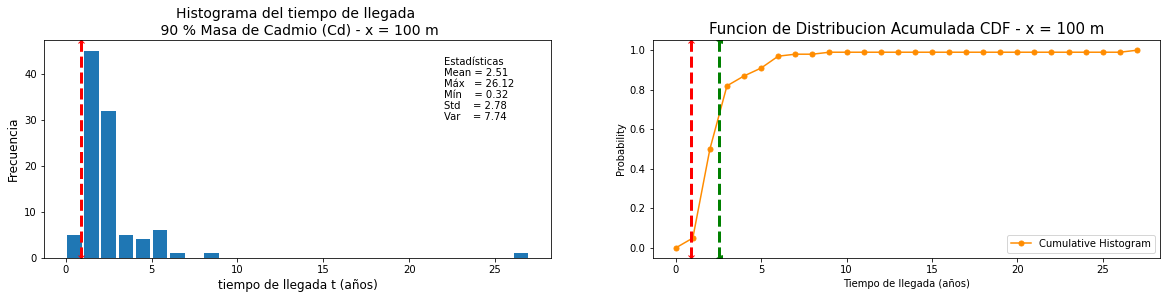

In [29]:
K=t_100ok
n=0
m=np.mean(K)
ma=np.max(K)
mi=np.min(K)
de=np.std(K)
va=np.var(K)

#Titulo de estadisticas
w_1 = "Mean = {:.2f}".format(m)
w_2 = "Máx   = {:.2f}".format(ma)
w_3 = "Mín    = {:.2f}".format(mi)
w_4 = "Std    = {:.2f}".format(de)
w_5 = "Var    = {:.2f}".format(va)
v=[w_1,w_2,w_3,w_4,w_5]

fig = plt.figure(figsize=(20,4))

ax = fig.add_subplot(1, 2, 1)
intervalos = np.arange(0,28,1) 
#indicamos los extremos de los intervalos
values, base, _ = plt.hist(x=K,bins=intervalos, rwidth=0.85)
plt.title('Histograma del tiempo de llegada \n 90 % Masa de Cadmio (Cd) - x = 100 m',fontsize=14)
plt.xlabel('tiempo de llegada t (años)',fontsize=12)
plt.ylabel('Frecuencia',fontsize=12)
plt.axvline(Kriging[n], color='r', linestyle='dashed',  marker='x',linewidth=3)

b1=42
b2=2.4
c=22
plt.text(c, b1,"Estadísticas",)
plt.text(c, b1-b2, v[0])
plt.text(c, b1-2*b2, v[1])
plt.text(c, b1-3*b2, v[2])
plt.text(c, b1-4*b2, v[3])
plt.text(c, b1-5*b2, v[4])
#calculo de CDF

ax = fig.add_subplot(1, 2, 2)

values = np.insert(values,0,0)
ax.plot(base, np.cumsum(values)/ np.cumsum(values)[-1], color='darkorange', 
            marker='o', linestyle='-', markersize = 5, label = "Cumulative Histogram" )
#plt.axhline(0.95, color='r', linestyle='dashed',  marker='<',linewidth=3)
plt.xlabel('Tiempo de llegada (años)')
plt.ylabel("Probability")
plt.title('Funcion de Distribucion Acumulada CDF - x = 100 m',fontsize=15)
plt.axvline(Kriging[n], color='r', linestyle='dashed',  marker='x',linewidth=3)
plt.axvline(m, color='g', linestyle='dashed',  marker='<',linewidth=3)
ax.legend()

plt.show() #dibujamos el histograma

Text(0.5, 1.0, 'modelo = 57')

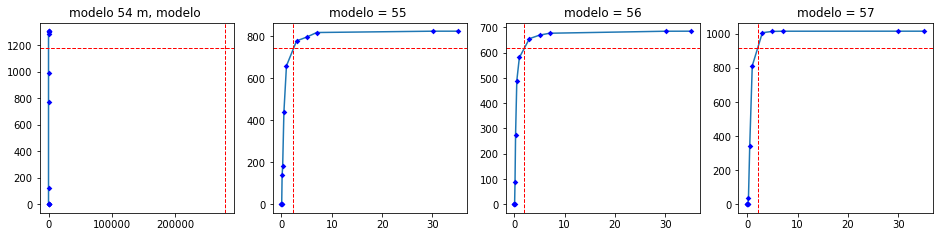

In [30]:
#modelo extenso ------- verificar valores
z=54 #MODELOS
l=0 #DISTANCIA
b_1=0
b_2=13
fig = plt.figure(figsize=(16,3.5))
ax = fig.add_subplot(1, 4, 1)


plt.plot(times_y[b_1:b_2],masa_Total[z][l][b_1:b_2], label='Masa de Cd', marker="D", markersize="2", markeredgewidth="2",
         markerfacecolor="b", markeredgecolor="b")
f_interp=InterpolatedUnivariateSpline(times_y,masa_Total[z][l],k=1)
times1=np.linspace(times_y[b_1:b_2],times_y[b_1:b_2],1000)
t1=f_interp(times1)
plt.plot(times1,t1)
#plt.fill_between(times1[b_1:b_2],t1[b_1:b_2],color='red', alpha=0.2)
plt.axhline(t_total[z][3]*.9, color='r', linestyle='dashed', linewidth=1)


inverse_90= inversefunc(f_interp, y_values=(t_total[z][3]*.9),domain=(times[0],times[13]), image=(times[0],times[14]),)
t_90.append(inverse_90)

plt.axvline(inverse_90, color='r', linestyle='dashed', linewidth=1)
plt.title('modelo {} m, modelo '.format((z)))
#-----------------------------
ax = fig.add_subplot(1, 4, 2)
plt.plot(times_y[b_1:b_2],masa_Total[z+1][l][b_1:b_2], label='Masa de Cd', marker="D", markersize="2", markeredgewidth="2",
         markerfacecolor="b", markeredgecolor="b")
f_interp=InterpolatedUnivariateSpline(times_y,masa_Total[z+1][l],k=1)
times1=np.linspace(times_y[b_1:b_2],times_y[b_1:b_2],1000)
t1=f_interp(times1)
plt.plot(times1,t1)
#plt.fill_between(times1[b_1:b_2],t1[b_1:b_2],color='red', alpha=0.2)
plt.axhline(t_total[z+1][3]*.9, color='r', linestyle='dashed', linewidth=1)


inverse_90= inversefunc(f_interp, y_values=(t_total[z+1][3]*.9),domain=(times[0],times[13]), image=(times[0],times[14]),)
t_90.append(inverse_90)

plt.axvline(inverse_90, color='r', linestyle='dashed', linewidth=1)
plt.title('modelo = {} '.format((z+1)))

#-----------------------------
ax = fig.add_subplot(1, 4, 3)
plt.plot(times_y[b_1:b_2],masa_Total[z+2][l][b_1:b_2], label='Masa de Cd', marker="D", markersize="2", markeredgewidth="2",
         markerfacecolor="b", markeredgecolor="b")
f_interp=InterpolatedUnivariateSpline(times_y,masa_Total[z+2][l],k=1)
times1=np.linspace(times_y[b_1:b_2],times_y[b_1:b_2],1000)
t1=f_interp(times1)
plt.plot(times1,t1)
#plt.fill_between(times1[b_1:b_2],t1[b_1:b_2],color='red', alpha=0.2)
plt.axhline(t_total[z+2][3]*.9, color='r', linestyle='dashed', linewidth=1)


inverse_90= inversefunc(f_interp, y_values=(t_total[z+2][3]*.9),domain=(times[0],times[13]), image=(times[0],times[14]),)
t_90.append(inverse_90)

plt.axvline(inverse_90, color='r', linestyle='dashed', linewidth=1)
plt.title('modelo = {}'.format((z+2)))

#-----------------------------
ax = fig.add_subplot(1, 4, 4)
plt.plot(times_y[b_1:b_2],masa_Total[z+3][l][b_1:b_2], label='Masa de Cd', marker="D", markersize="2", markeredgewidth="2",
         markerfacecolor="b", markeredgecolor="b")
f_interp=InterpolatedUnivariateSpline(times_y,masa_Total[z+3][l],k=1)
times1=np.linspace(times_y[b_1:b_2],times_y[b_1:b_2],1000)
t1=f_interp(times1)
plt.plot(times1,t1)
#plt.fill_between(times1[b_1:b_2],t1[b_1:b_2],color='red', alpha=0.2)
plt.axhline(t_total[z+3][3]*.9, color='r', linestyle='dashed', linewidth=1)


inverse_90= inversefunc(f_interp, y_values=(t_total[z+3][3]*.9),domain=(times[0],times[13]), image=(times[0],times[14]),)
t_90.append(inverse_90)

plt.axvline(inverse_90, color='r', linestyle='dashed', linewidth=1)
plt.title('modelo = {}'.format((z+3)))
#print(inverse_90)
#print(inverse_90)

2.2545992783419257


Text(0.5, 1.0, 'modelo 54 m, modelo ')

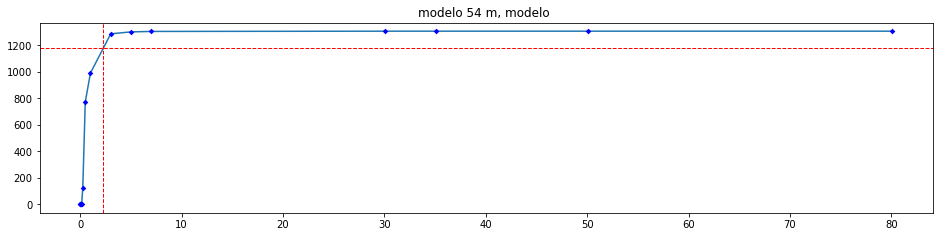

In [31]:
#verificar valores
z=54 #modelo
l=0 #distancia
fig = plt.figure(figsize=(16,3.5))
ax = fig.add_subplot(1, 1, 1)
b_1=0
b_2=15

plt.plot(times_y[b_1:b_2],masa_Total[z][l][b_1:b_2], label='Masa de Cd', marker="D", markersize="2", markeredgewidth="2",
         markerfacecolor="b", markeredgecolor="b")
f_interp=InterpolatedUnivariateSpline(times_y,masa_Total[z][l],k=1)
times1=np.linspace(times_y[b_1:b_2],times_y[b_1:b_2],1000)
t1=f_interp(times1)
plt.plot(times1,t1)
#plt.fill_between(times1[b_1:b_2],t1[b_1:b_2],color='red', alpha=0.2)
plt.axhline(t_total[z][3]*.9, color='r', linestyle='dashed', linewidth=1)


inverse_90= inversefunc(f_interp, y_values=(t_total[z][3]*.9), image=(times[0],times[14]),)
t_90.append(inverse_90)
print(inverse_90)
plt.axvline(inverse_90, color='r', linestyle='dashed', linewidth=1)
plt.title('modelo {} m, modelo '.format((z)))